In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
TRAIN_DATA_PATH = "data/train"
TEST_DATA_PATH = "data/test"
VAL_DATA_PATH = "data/val"

# Подготовка датасета + аугментации

In [3]:
class FacadeDataset(Dataset):
    
    def __init__(self, root_dir, transform=None, is_input_image=False):
        self.root_dir = root_dir
        self.transform = transform
        self.n_samples = os.listdir(self.root_dir)
        self.is_input_image = is_input_image
        
    def __len__(self):
        return len(self.n_samples)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        image_name = self.n_samples[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = np.asarray(Image.open(image_path).convert("RGB"))
        height, width, _ = image.shape
        width_cutoff = width // 2
        if self.is_input_image:
            sample = image[:, width_cutoff:, :]
        else:
            sample = image[:, :width_cutoff, :]
        
        if self.transform:
            sample = self.transform(sample)  
        
        return sample


In [4]:
class Resize:
    
    def __init__(self, output_size=284):
        self.output_size = output_size

    def __call__(self, sample):
        sample = cv2.resize(sample, (self.output_size, self.output_size))
        return sample
    
    
class RandomCrop:
    
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        h, w = sample.shape[:2]
        top = np.random.randint(0, h - self.output_size)
        left = np.random.randint(0, w - self.output_size)
        sample = sample[
            top: top + self.output_size,
            left: left + self.output_size
        ]  
        return sample
    

class RandomHorizontalFlip:
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        if np.random.random() > self.p:
            sample = cv2.flip(sample, 1)
        return sample
    
    
class Normalize:
    def __call__(self, sample):
        sample = sample / 127.5 - 1
        return sample
    
    
class ToTensor:
    # numpy image: H x W x C
    # torch image: C x H x W
    def __call__(self, sample):
        sample = sample.transpose((2, 0, 1)).astype(np.float32)
        sample = torch.from_numpy(sample)
        return sample
    

In [5]:
def get_dataloader(path, batch_size=8, num_workers=0, val=False, is_input_image=False):
    
    if not val:
        train_transform = transforms.Compose(
            [
                Resize(284), 
                RandomCrop(256),
                RandomHorizontalFlip(0.5),
                Normalize(),
                ToTensor(),
            ]
        )
        dataset = FacadeDataset(root_dir=path, transform=train_transform, is_input_image=is_input_image)
        dataloader = DataLoader(
            dataset, 
            batch_size=batch_size,
            shuffle=True, 
            drop_last=True,
            num_workers=num_workers,
        )  
    else:
        val_transform = transforms.Compose(
            [
                Normalize(),
                ToTensor(),
            ]
        )
        dataset = FacadeDataset(root_dir=path, transform=val_transform, is_input_image=is_input_image)
        dataloader = DataLoader(
            dataset, 
            batch_size=batch_size,
            shuffle=True, 
            drop_last=False,
            num_workers=num_workers,
        )
        
    return dataloader

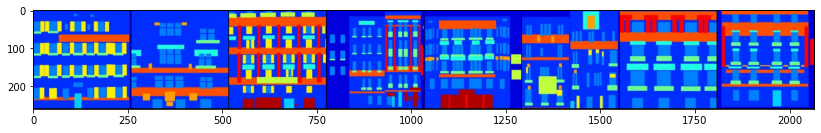

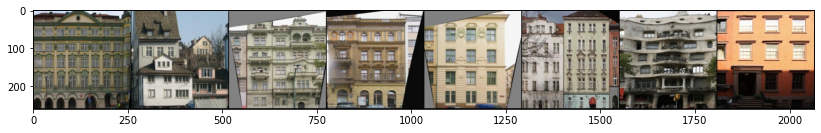

In [6]:
train_dataloader_input_image = get_dataloader(TRAIN_DATA_PATH, is_input_image=True)
train_dataloader_real_image = get_dataloader(TRAIN_DATA_PATH, is_input_image=False)

for input_image, real_image in zip(train_dataloader_input_image, train_dataloader_real_image):
    
    input_image = ((input_image + 1) * 127.5).int()
    real_image = ((real_image + 1) * 127.5).int()

    grid = utils.make_grid(input_image)
    plt.figure(figsize=(14, 5))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    grid = utils.make_grid(real_image)
    plt.figure(figsize=(14, 5))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    break

# Генератор

In [7]:
class BlockDown(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=2, padding=1, use_batch_norm=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=4, 
                stride=stride, 
                padding=padding, 
                bias=False, 
                padding_mode="reflect"  # zeros
            )
        )
        if use_batch_norm:
            self.conv.append(nn.InstanceNorm2d(out_channels))
        self.conv.append(nn.LeakyReLU(0.2))
        nn.init.normal_(self.conv[0].weight, 0, 0.02)
    
    def forward(self,x):
        x = self.conv(x)
        return x
    
    
class BlockUp(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=2, padding=1, use_batch_norm=True, use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=4, 
                stride=stride, 
                padding=padding, 
                bias=False,
            )
        )
        if use_batch_norm:
            self.conv.append(nn.InstanceNorm2d(out_channels))
        if use_dropout:
            self.conv.append(nn.Dropout(0.5))
        self.conv.append(nn.ReLU())
        nn.init.normal_(self.conv[0].weight, 0, 0.02)
    
    def forward(self,x):
        x = self.conv(x)
        return x


class Generator(nn.Module):
    ### Unet
    
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        
        ##############################################################################
        ################################## ENCODER ###################################
        ##############################################################################
        self.down1 = BlockDown(in_channels, features, use_batch_norm=False)  # 64 X 128 X 128
        self.down2 = BlockDown(features, 2 * features)  # 128 X 64 X 64
        self.down3 = BlockDown(2 * features, 4 * features)  # 256 X 32 X 32
        self.down4 = BlockDown(4 * features, 8 * features)  # 512 X 16 X 16
        self.down5 = BlockDown(8 * features, 8 * features)  # 512 X 8 X 8
        self.down6 = BlockDown(8 * features, 8 * features)  # 512 X 4 X 4
        self.down7 = BlockDown(8 * features, 8 * features)  # 512 X 2 X 2
        self.bottleneck = BlockDown(8 * features, 8 * features, use_batch_norm=False)  # 512 X 1 X 1
        
        ##############################################################################
        ################################## DECODER ###################################
        ##############################################################################
        self.up1 = BlockUp(8 * features, 8 * features, use_dropout=True)
        self.up2 = BlockUp(16 * features, 8 * features, use_dropout=True)
        self.up3 = BlockUp(16 * features, 8 * features, use_dropout=True)
        self.up4 = BlockUp(16 * features, 8 * features)
        self.up5 = BlockUp(16 * features, 4 * features)
        self.up6 = BlockUp(8 * features, 2 * features)
        self.up7 = BlockUp(4 * features, features)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(2 * features, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        nn.init.normal_(self.final_up[0].weight, 0, 0.02)
        
    def forward(self,x):
        
        # encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.bottleneck(d7)
        
        # decoder
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        final_up = self.final_up(torch.cat([u7, d1], 1))
        
        return final_up
        

# Дискриминатор

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, in_channels=3, features = [64, 128, 256, 512]):
        super().__init__()
        self.down1 = BlockDown(in_channels, features[0], use_batch_norm=False)
        self.down2 = BlockDown(features[0], features[1], padding=0)  # padding=1
        self.down3 = BlockDown(features[1], features[2], padding=0)  # padding=1
        self.down4 = BlockDown(features[2], features[3], padding=0, stride=1)  # padding=1
        self.down5 = BlockDown(features[3], 1, stride=1, use_batch_norm=False)
        
    def forward(self, x):
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        x = self.down5(x)
        return x
    

# Функция потерь

In [9]:
def generator_loss(real_A, real_B, recon_A, recon_B, discr_A_fake, discr_B_fake, l1_loss, l2_loss, lambda_coef):
    """Функция потерь для генератора."""
    
    generator_A_loss = l2_loss(discr_B_fake, torch.ones_like(discr_B_fake))
    cycle_A_loss = l1_loss(recon_A, real_A) * LAMBDA
    generator_B_loss = l2_loss(discr_B_fake, torch.ones_like(discr_B_fake))
    cycle_B_loss = l1_loss(recon_B, real_B) * LAMBDA
    
    total_loss = generator_A_loss + cycle_A_loss + generator_B_loss + cycle_B_loss
 
    return total_loss
     

def discriminator_loss(discr_real, discr_fake, l2_loss, coef=.5):
    """Функция потерь для дискриминатора."""
    
    real_loss = l2_loss(discr_real, torch.ones_like(discr_real))
    fake_loss = l2_loss(discr_fake, torch.zeros_like(discr_fake))

    total_loss = coef * (real_loss + fake_loss)
    
    return total_loss


# Обучение

In [46]:
BATCH_SIZE = 1
NUM_WORKERS = 2
LAMBDA = 10
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999
N_EPOCHS = 80

In [11]:
generator_A = Generator().cuda()
generator_B = Generator().cuda()
discriminator_A = Discriminator().cuda()
discriminator_B = Discriminator().cuda()

generator_optimizer = torch.optim.Adam(
    list(generator_A.parameters()) + list(generator_B.parameters()), 
    lr=LR, betas=(BETA1, BETA2)
)
discriminator_A_optimizer = torch.optim.Adam(
    discriminator_A.parameters(), lr=LR, betas=(BETA1, BETA2)
)
discriminator_B_optimizer = torch.optim.Adam(
    discriminator_B.parameters(), lr=LR, betas=(BETA1, BETA2)
)

l1_loss = nn.L1Loss()
l2_loss = nn.MSELoss()

train_dataloader_A = get_dataloader(
    TRAIN_DATA_PATH, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val=False, is_input_image=True
)
train_dataloader_B = get_dataloader(
    TRAIN_DATA_PATH, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val=False, is_input_image=False
)
val_dataloader_A = get_dataloader(
    VAL_DATA_PATH, batch_size=8, num_workers=NUM_WORKERS, val=True, is_input_image=True
)
val_dataloader_B = get_dataloader(
    VAL_DATA_PATH, batch_size=8, num_workers=NUM_WORKERS, val=True, is_input_image=False
)

In [20]:
def step(real_A, real_B):
    
    # train generator
    # A -> B
    fake_B = generator_A(real_A)
    discr_B_fake = discriminator_B(fake_B)
    recon_A = generator_B(fake_B)
    # B -> A
    fake_A = generator_B(real_B)
    discr_A_fake = discriminator_A(fake_A)
    recon_B = generator_A(fake_A)
    # loss
    g_loss = generator_loss(
        real_A, real_B, recon_A, recon_B, discr_A_fake, discr_B_fake, l1_loss, l2_loss, LAMBDA
    )
    generator_optimizer.zero_grad()
    g_loss.backward()
    generator_optimizer.step()
    
    # train discriminator A
    discr_A_real = discriminator_A(real_A)
    discr_A_fake = discriminator_A(fake_A.detach())
    # loss
    d_A_loss = discriminator_loss(discr_A_real, discr_A_fake, l2_loss, coef=.5)
    discriminator_A_optimizer.zero_grad()
    d_A_loss.backward()
    discriminator_A_optimizer.step()
    
    # train discriminator_B
    discr_B_real = discriminator_B(real_B)
    discr_B_fake = discriminator_B(fake_B.detach())
    # loss
    d_B_loss = discriminator_loss(discr_B_real, discr_B_fake, l2_loss, coef=.5)
    discriminator_B_optimizer.zero_grad()
    d_B_loss.backward()
    discriminator_B_optimizer.step()
    
    return g_loss.item(), d_A_loss.item(), d_B_loss.item()


def plot_generator_results(dataloader, generator):
    
    for batch in dataloader:
        break
    
    with torch.no_grad():
        fake_image = generator(batch)
        fake_image = ((fake_image + 1) * 127.5).int()
    
    batch = ((batch + 1) * 127.5).int()

    grid = utils.make_grid(batch)
    plt.figure(figsize=(14, 5))
    plt.title("INPUT IMAGES")
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    grid = utils.make_grid(fake_image)
    plt.figure(figsize=(14, 5))
    plt.title("GENERATED IMAGES")
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


In [13]:
dis_A_loss = []
dis_B_loss = []
gen_loss = []

In [47]:
for epoch in range(N_EPOCHS):
    
    pbar = tqdm(zip(train_dataloader_A, train_dataloader_B))
    pbar.set_description(f"epoch={epoch}")
    
    for input_image, real_image in pbar:
    # for input_image, real_image in zip(train_dataloader_A, train_dataloader_B):
        
        loss_ = step(
            real_A=input_image.cuda(), real_B=real_image.cuda()
        )
        gen_loss.append(loss_[0])
        dis_A_loss.append(loss_[1])
        dis_B_loss.append(loss_[2])
        
        pbar.set_postfix(gen_loss=loss_[0], dis_A_loss=loss_[1], dis_B_loss=loss_[2])
        
    if epoch == 0 or (epoch + 1) % 5 == 0:
      torch.save(generator_A, f"cyclegan-checkpoints/generator_A_epoch_{epoch + 1}.pkl")
      torch.save(generator_B, f"cyclegan-checkpoints/generator_B_epoch_{epoch + 1}.pkl")
      torch.save(discriminator_A, f"cyclegan-checkpoints/discriminator_A_epoch_{epoch + 1}.pkl")
      torch.save(discriminator_B, f"cyclegan-checkpoints/discriminator_B_epoch_{epoch + 1}.pkl")
    

epoch=70: : 400it [01:18,  5.10it/s, dis_A_loss=0.00612, dis_B_loss=0.264, gen_loss=1.95]
epoch=71: : 400it [01:17,  5.15it/s, dis_A_loss=0.00523, dis_B_loss=0.171, gen_loss=1.71]
epoch=72: : 400it [01:18,  5.13it/s, dis_A_loss=0.00231, dis_B_loss=0.28, gen_loss=0.859]
epoch=73: : 400it [01:16,  5.23it/s, dis_A_loss=0.00278, dis_B_loss=0.0675, gen_loss=1.96]
epoch=74: : 400it [01:16,  5.23it/s, dis_A_loss=0.0127, dis_B_loss=0.364, gen_loss=0.82]
epoch=75: : 400it [01:16,  5.22it/s, dis_A_loss=0.00306, dis_B_loss=0.231, gen_loss=1.22]
epoch=76: : 400it [01:16,  5.23it/s, dis_A_loss=0.00387, dis_B_loss=0.282, gen_loss=2.28]
epoch=77: : 400it [01:16,  5.23it/s, dis_A_loss=0.0038, dis_B_loss=0.189, gen_loss=0.954]
epoch=78: : 400it [01:16,  5.22it/s, dis_A_loss=0.00475, dis_B_loss=0.349, gen_loss=2.27]
epoch=79: : 400it [01:16,  5.23it/s, dis_A_loss=0.0128, dis_B_loss=0.257, gen_loss=0.931]


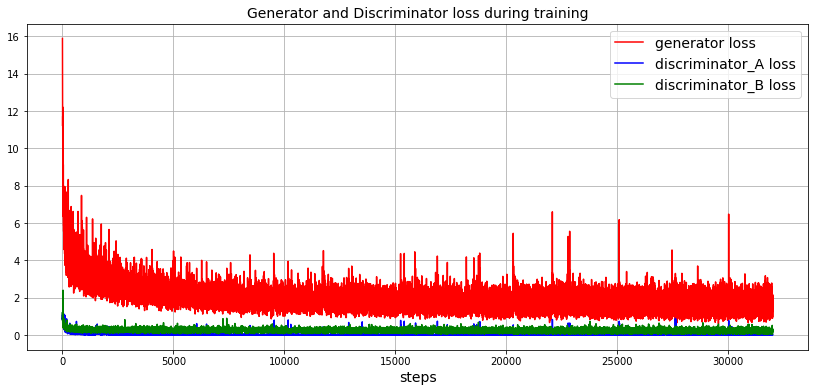

In [48]:
plt.figure(figsize=(14, 6))
plt.plot(gen_loss, label="generator loss", color="red")
plt.plot(dis_A_loss, label="discriminator_A loss", color="blue")
plt.plot(dis_B_loss, label="discriminator_B loss", color="green")
plt.title("Generator and Discriminator loss during training", fontsize=14)
plt.xlabel("steps", fontsize=14)
plt.grid("--")
plt.legend(fontsize=14);

# Результаты после 1-й эпохи на валидационной выборке

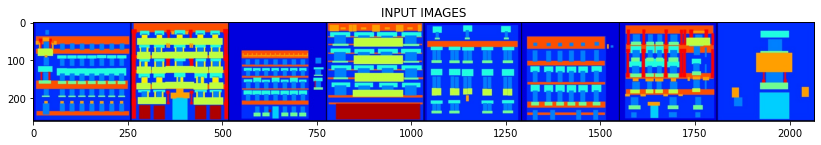

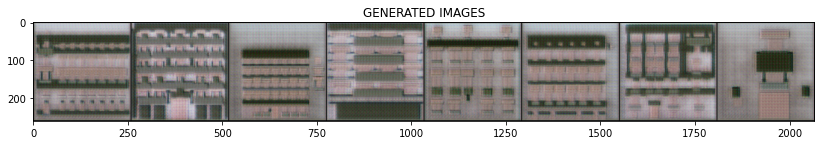

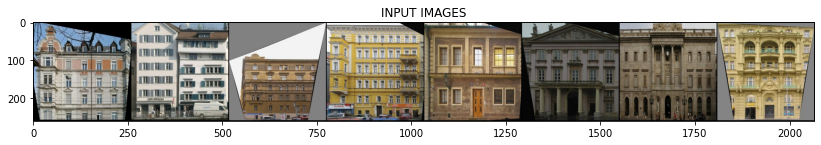

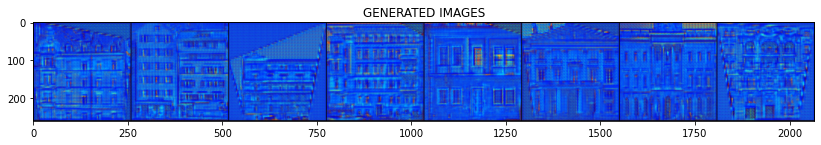

In [21]:
generator_A_ = torch.load("generator_A_epoch_1.pkl").cpu()
generator_B_ = torch.load("generator_B_epoch_1.pkl").cpu()
plot_generator_results(val_dataloader_A, generator_A_)
plot_generator_results(val_dataloader_B, generator_B_)

# Результаты после 5-й эпохи на валидационной выборке

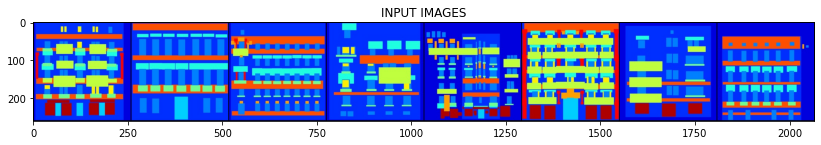

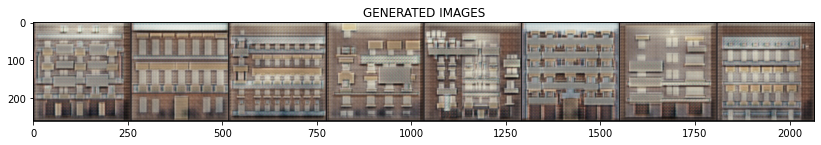

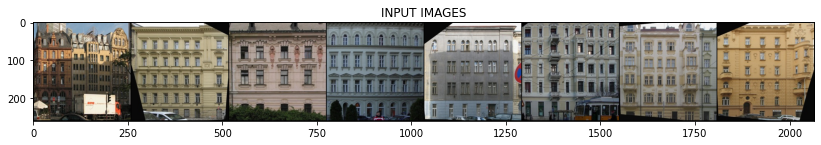

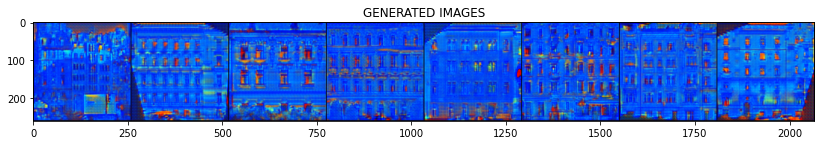

In [22]:
generator_A_ = torch.load("generator_A_epoch_5.pkl").cpu()
generator_B_ = torch.load("generator_B_epoch_5.pkl").cpu()
plot_generator_results(val_dataloader_A, generator_A_)
plot_generator_results(val_dataloader_B, generator_B_)

# Результаты после 20-й эпохи на валидационной выборке

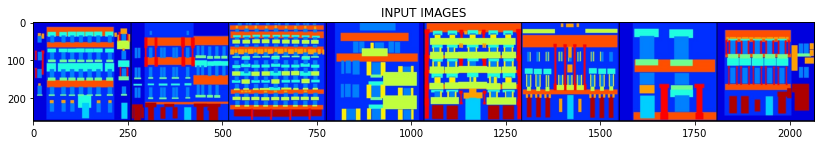

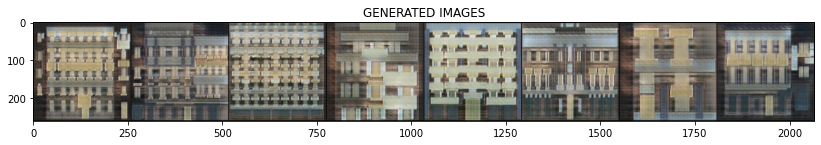

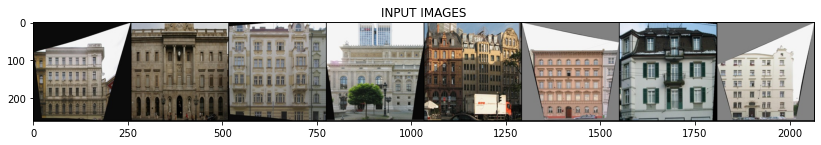

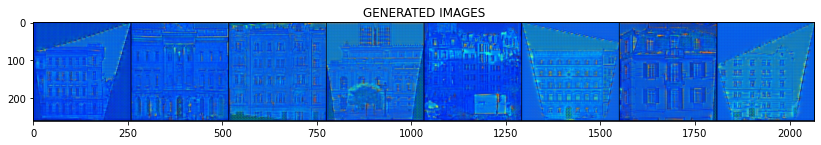

In [36]:
generator_A_ = torch.load("generator_A_epoch_20.pkl").cpu()
generator_B_ = torch.load("generator_B_epoch_20.pkl").cpu()
plot_generator_results(val_dataloader_A, generator_A_)
plot_generator_results(val_dataloader_B, generator_B_)

# Результаты после 50-й эпохи на валидационной выборке

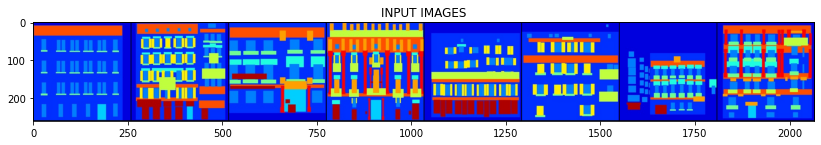

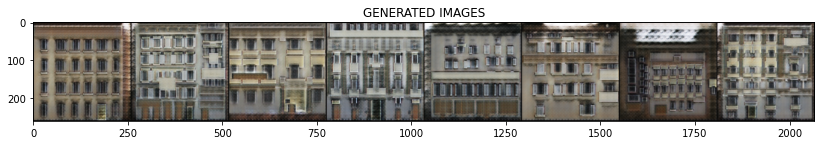

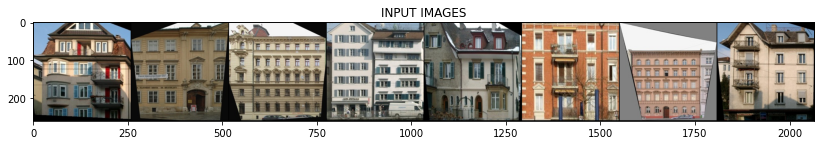

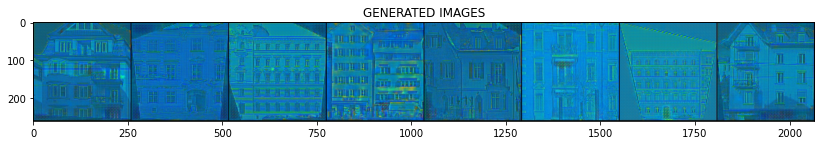

In [33]:
generator_A_ = torch.load("generator_A_epoch_50.pkl").cpu()
generator_B_ = torch.load("generator_B_epoch_50.pkl").cpu()
plot_generator_results(val_dataloader_A, generator_A_)
plot_generator_results(val_dataloader_B, generator_B_)

# Результаты после 80-й эпохи на валидационной выборке

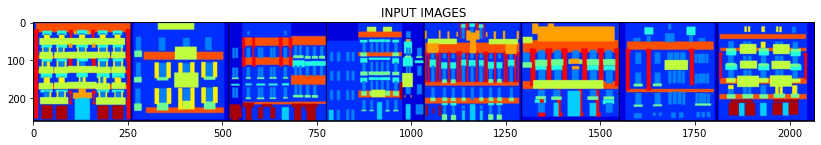

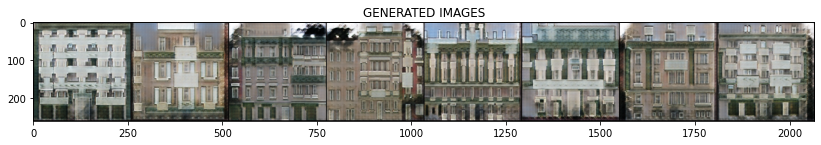

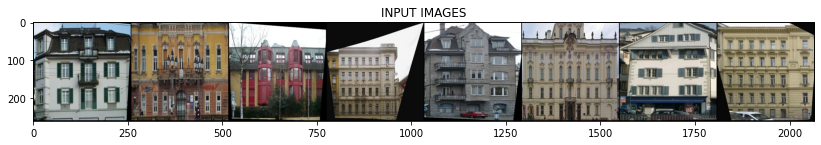

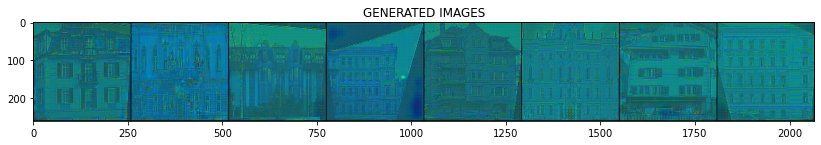

In [51]:
generator_A_ = torch.load("generator_A_epoch_80.pkl").cpu()
generator_B_ = torch.load("generator_B_epoch_80.pkl").cpu()
plot_generator_results(val_dataloader_A, generator_A_)
plot_generator_results(val_dataloader_B, generator_B_)